# Imports

In [1]:
import numpy as np
from pprint import pprint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=6, suppress=True)

# References

### puma560 foward and inverse kinematics articles

> https://hive.blog/hive-196387/@juecoree/forward-kinematics-of-puma-560-robot-using-dh-method

> https://hive.blog/hive-196387/@juecoree/inverse-kinematics-of-puma-560-robot#:~:text=The%20mathematical%20model%20of%20the,for%20a%20given%20joint%20angles.

### DH Table parameters Explanation

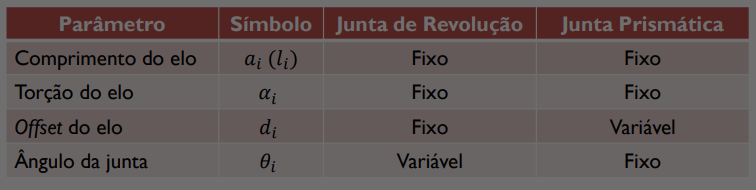

### DH Table values to puma560 robot

| Frame | θ   | α    | r         | d         |
|-------|-----|------|-----------|-----------|
| 1     | θ 1 | -90o | 0         | 671.83 mm |
| 2     | θ 2 | 0o   | 431.80 mm | 139.70 mm |
| 3     | θ 3 | 90o  | -20.32 mm | 0         |
| 4     | θ 4 | -90o | 0         | 431.80 mm |
| 5     | θ 5 | 90o  | 0         | 0         |
| 6     | θ 6 | 0o   | 0         | 56.50 mm  |

In [2]:
dh_table = np.array([
    
    [np.pi/2,   -np.pi/2,          0,      0.67183],
    [      0,           0,    0.43180,     0.13970],
    [      0,     np.pi/2,   -0.02032,           0],
    [      0,    -np.pi/2,         0,      0.43180],
    [      0,     np.pi/2,         0,            0],
    [      0,           0,         0,      0.05650]
    
])

dh_table = np.array([
    
    [     0.,   0.,          1.,      0.],
    # [     0.,   0.,          1.,      0.]

]) 

In [3]:
dh_table

array([[0., 0., 1., 0.]])

### $T_{0}^{n-1}$ transformation matrix

$$ _0^nT \ \ = \ \ _0^1T \ \ _1^2T \ \ ... \ \ _{n-1}^nT  $$

$$
_{i-1}^iT = \begin{bmatrix}
\cos\theta_i & -\sin\theta_i\cos\alpha_i & sin\theta_i\sin\alpha_i & r_i\cos\theta_i \\
\sin\theta_i & \cos\theta_i\cos\alpha_i & -\cos\theta_i\sin\alpha_i & r_i\sin\theta_i \\
0 & \sin\alpha_i & \cos\alpha_i & d_i \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

# Dataset build functions

### utils functions

In [4]:
def dh_transform(theta, alpha, r, d):

    ct = np.cos(theta)
    st = np.sin(theta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    T = np.array([[ct, -st*ca, st*sa, r*ct],
                  [st, ct*ca, -ct*sa, r*st],
                  [0, sa, ca, d],
                  [0, 0, 0, 1]])
    return T

def fkine(theta, alpha, r, d, offset=np.array([0.])): #, 0, 0, 0, 0])):

    # print(f"Thetas = {theta}")
    # print(f"alphas = {alpha}")
    # print(f"rs = {r}")
    # print(f"ds = {d}\n")

    T = np.eye(4)
    theta = theta + offset

    for i in range(len(theta)):
        T_i = dh_transform(theta[i], alpha[i], r[i], d[i])
        T = np.dot(T, T_i)

    return T

def get_position(thetas):

  _dh_table = [thetas] + [dh_table[:,i] for i in range(1, 4)]
  matrix_t = fkine(*_dh_table)

  # pprint(matrix_t)

  xyz = matrix_t[:-1, -1]

  r20 = matrix_t[2, 0]
  r21 = matrix_t[2, 1]
  r22 = matrix_t[2, 2]
  r10 = matrix_t[1, 0]
  r00 = matrix_t[0, 0]

  # print(f"\nr20 = DH TABLE[2,0] = {r20}")
  # print(f"r21 = DH TABLE[2,1] = {r21}")
  # print(f"r22 = DH TABLE[2,2] = {r22}")
  # print(f"r10 = DH TABLE[1,0] = {r10}")
  # print(f"r00 = DH TABLE[0,0] = {r00}\n\n")

  pitch = np.arctan2(-r20, np.sqrt(r21**2 + r22**2))
  roll = np.arctan2(r10/np.cos(pitch), r00/np.cos(pitch))
  yaw = np.arctan2(r21/np.cos(pitch), r22/np.cos(pitch))

  # print("pitch = arcotan2(-r20, sqrt(r21^2 + r22^2))\n")
  
  # print("r21^2 = ", r21**2)
  # print("r22^2 = ", r22**2)
  # print("r21^2 + r22^2 = ", r21**2 + r22**2)
  # print("sqrt(r21^2 + r22^2) = ", np.sqrt(r21**2 + r22**2))
  # print("arcotan2(-r20, sqrt(r21^2 + r22^2)) = ", np.arctan2(-r20, np.sqrt(r21**2 + r22**2)))

  # print("\nroll = arcotan2(r10/cos(pitch), r00/cos(pitch))\n")
  # print(f"cos(pitch) = {np.cos(pitch)}")
  # print(f"r00/cos(pitch) = {r00/np.cos(pitch)}")
  # print(f"r10/cos(pitch) = {r10/np.cos(pitch)}")
  # print(f"arcotan2(r10/cos(pitch), r00/cos(pitch)) = {np.arctan2(r10/np.cos(pitch), r00/np.cos(pitch))}")
  
  # print("\nyaw = arcotan2(r21/cos(pitch), r22/cos(pitch))\n")
  # print(f"cos(pitch) = {np.cos(pitch)}")
  # print(f"r21/cos(pitch) = {r21/np.cos(pitch)}")
  # print(f"r22/cos(pitch) = {r22/np.cos(pitch)}")
  # print(f"arcotan2(r21/cos(pitch), r22/cos(pitch)) = {np.arctan2(r21/np.cos(pitch), r22/np.cos(pitch))}")
  
  
  # return [roll, pitch, yaw] + list(xyz)
  return xyz

In [5]:
# get_position(thetas[0, :])

In [6]:
# fkine(*[dh_table[:,i] for i in range(4)])

In [7]:
# for name, col in zip(["Thetas", "Alphas", "Ds", "As"], [dh_table[:,i] for i in range(4)]):
  # print(name, col)

In [8]:
get_position([np.pi/2])

array([0., 1., 0.])

### Puma560 angles rotations contraints

In [9]:
angle_ranges = np.array([(-np.pi, np.pi)]) # np.array([[-2.792, 2.792], [-3.9269, 0.7854], [-0.7854, 3.9269], [-1.9198, 2.967], [-1.7453, 1.7453], [-4.6425, 4.6425]])

### Generate Dataset with N samples randomly

In [10]:
#n samples
N = 10000

# thethas = [theta_joint0, theta_joint1, theta_joint2, theta_joint3, theta_joint4, theta_joint5]
thetas = np.array([
    np.random.uniform(low=low, high=high, size=N) for i, (low, high) in enumerate(angle_ranges)
]).T

In [11]:
pprint(thetas)
pprint(thetas.shape)

array([[ 1.455979],
       [ 3.052979],
       [-2.052164],
       ...,
       [-1.270693],
       [ 0.490728],
       [-1.386476]])
(10000, 1)


In [12]:
#!pip install "roboticstoolbox-python"

In [13]:
dh_table

array([[0., 0., 1., 0.]])

In [14]:
import roboticstoolbox as rtb
robot = rtb.models.DH.Puma560()
print(robot)

ModuleNotFoundError: No module named 'roboticstoolbox'

In [ ]:
puma560 = rtb.models.DH.Puma560()

In [ ]:
0.4521, -0.15 , 1.104

In [ ]:
puma560.fkine(np.zeros(6))

In [ ]:
get_position([-1.06, 0.78, 0, 0, 0, 0])

In [16]:

#positions = [[x0, y0, z0],...,[xn-1, yn-1, zn-1]]

positions = np.array(
    [get_position(theta) for theta in thetas]
)


In [17]:

pprint(positions.shape)

(10000, 3)


To make pose of puma560 robot calculation using python script, you can use the Robotics Toolbox for Python (RTB-P) which provides a Puma560 class that models the kinematics and dynamics of the robot using standard Denavit-Hartenberg notation¹. Here is an example of using the RTB-P to create a Puma560 robot object and calculate its forward and inverse kinematics:

```python
import roboticstoolbox as rtb
import numpy as np

# Create a Puma560 robot object
robot = rtb.models.DH.Puma560()

# Define a joint configuration
q = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Calculate the forward kinematics
T = robot.fkine(q) # T is a SE3 object representing the end-effector pose

# Print the end-effector pose
print(T)

# Calculate the inverse kinematics
q_inv = robot.ikine_a(T) # q_inv is a numpy array of joint angles

# Print the inverse kinematics solution
print(q_inv)
```

The output is:

```python
  T = 
    0.5137   -0.8579    0.0008    0.5669
    0.8579    0.5137   -0.0008   -0.0573
   -0.0008   -0.0008   -1.0000    0.5963
         0         0         0    1.0000

q_inv = [ 0.1   0.2   0.3   0.4   0.5   0.6 ]
```

Origem: conversa com o Bing, 4/7/2023(1) Introduction — Robotics Toolbox for Python documentation. https://petercorke.github.io/robotics-toolbox-python/intro.html Acessado 4/7/2023.
(2) roboticstoolbox.models.URDF.Puma560 — Robotics Toolbox for Python .... https://petercorke.github.io/robotics-toolbox-python/_modules/roboticstoolbox/models/URDF/Puma560.html Acessado 4/7/2023.
(3) Kinematics · petercorke/robotics-toolbox-python Wiki · GitHub. https://github.com/petercorke/robotics-toolbox-python/wiki/Kinematics Acessado 4/7/2023.
(4) robotics-toolbox-python/Puma560.py at master - Github. https://github.com/petercorke/robotics-toolbox-python/blob/master/roboticstoolbox/models/DH/Puma560.py Acessado 4/7/2023.
(5) GitHub - liviobisogni/puma560-control: Control of a PUMA 560 robot arm .... https://github.com/liviobisogni/puma560-control Acessado 4/7/2023.

### Data split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(positions, thetas, test_size=0.10, random_state=42)

In [19]:
[m.shape for m in [X_train, y_train, X_test, y_test]]

[(9000, 3), (9000, 1), (1000, 3), (1000, 1)]

In [20]:
X_train[0]

array([0.089016, 0.99603 , 0.      ])

In [21]:
y_train[0]

array([1.481663])

# Data visualization

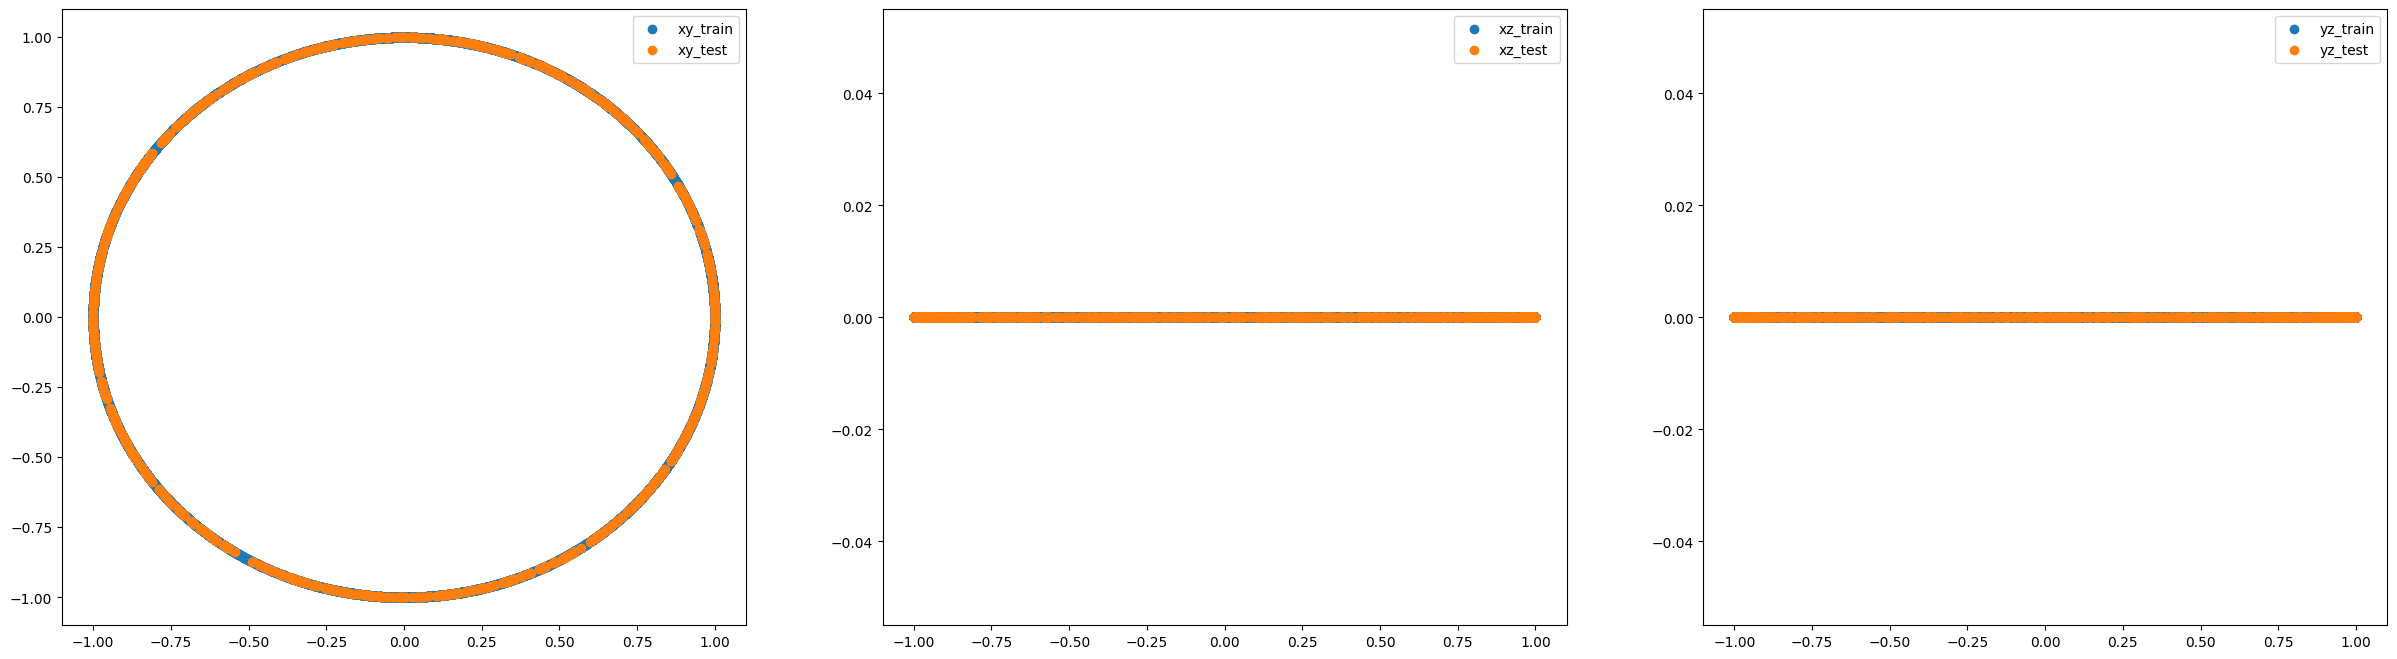

In [22]:
import mpl_toolkits.mplot3d

x, y, z = X_train[:, -3], X_train[:, -2], X_train[:, -1]
x2, y2, z2 = X_test[:, -3], X_test[:, -2], X_test[:, -1]

plt.figure(figsize=(30, 8))
plt.subplot(1,3,1)
plt.scatter(x, y, label='xy_train')
plt.scatter(x2, y2, label='xy_test')
plt.legend()


plt.subplot(1,3,3)
plt.scatter(y, z, label='yz_train')
plt.scatter(y2, z2, label='yz_test')
plt.legend()

plt.subplot(1,3,2)
plt.scatter(x, z, label='xz_train')
plt.scatter(x2, z2, label='xz_test')
plt.legend()

plt.show()

# Model Design

In [23]:
def build_model(input_dim, output_dim):

  model = Sequential()
  model.add(Dense(units=32, activation='relu', input_dim=input_dim))
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(units=output_dim))

  return model

In [24]:
model_params = {
    'optimizer':'adam',
    'loss':'mse',
    'metrics': ['mse']
}

In [25]:
model = build_model(positions.shape[1], thetas.shape[1])
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt, 
    loss=model_params['loss'],
    metrics=model_params['metrics']
)

history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=50, validation_data=(X_test,y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19,137
Trainable params: 19,137
Non-traina

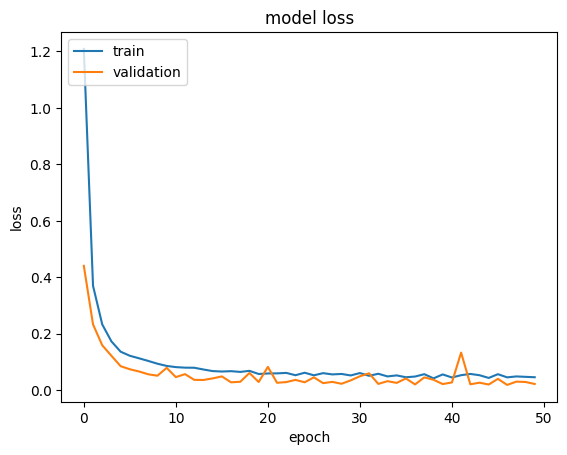

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 655us/step - loss: 0.0218 - mse: 0.0218


[0.021807802841067314, 0.021807802841067314]

In [28]:
model.predict(np.array([-1.06, 0.78, 0, 0, 0, 0]))

ValueError: in user code:

    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\walme\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [29]:
y_hat = model.predict(X_test[0].reshape(1,-1), verbose=0)[0]

print(f"Original  Thetas {y_test[0]}")
print(f"Predicted Thetas {y_hat}")

Original  Thetas [2.715993]
Predicted Thetas [2.690219]


In [30]:
true_position = get_position(y_test[0])
pred_position = get_position(y_hat)

print(f"Position given by theta label {true_position}")
print(f"Position given by theta pred  {pred_position}")

Position given by theta label [-0.910791  0.412867  0.      ]
Position given by theta pred  [-0.899849  0.436202  0.      ]


In [31]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Please install GPU version of TF


In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
